In [18]:

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os as os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Activation
)  
import glob as glob

In [19]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("C:/Users/Mohnish Deorukhkar/Desktop/Python/ASSIGNMENT/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("C:/Users/Mohnish Deorukhkar/Desktop/Python/ASSIGNMENT/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [20]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [21]:
batch_size = 32
img_height = 180
img_width = 180

In [22]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # ✅ Should be between 0 and 1 (e.g., 0.2 for 80% train, 20% validation)
    subset="training",  # ✅ Required when using validation_split
    seed=123,  # Ensuring reproducibility
    image_size=(img_height, img_width),  # Resizing images
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [23]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",  # ✅ Validation subset
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [24]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [25]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


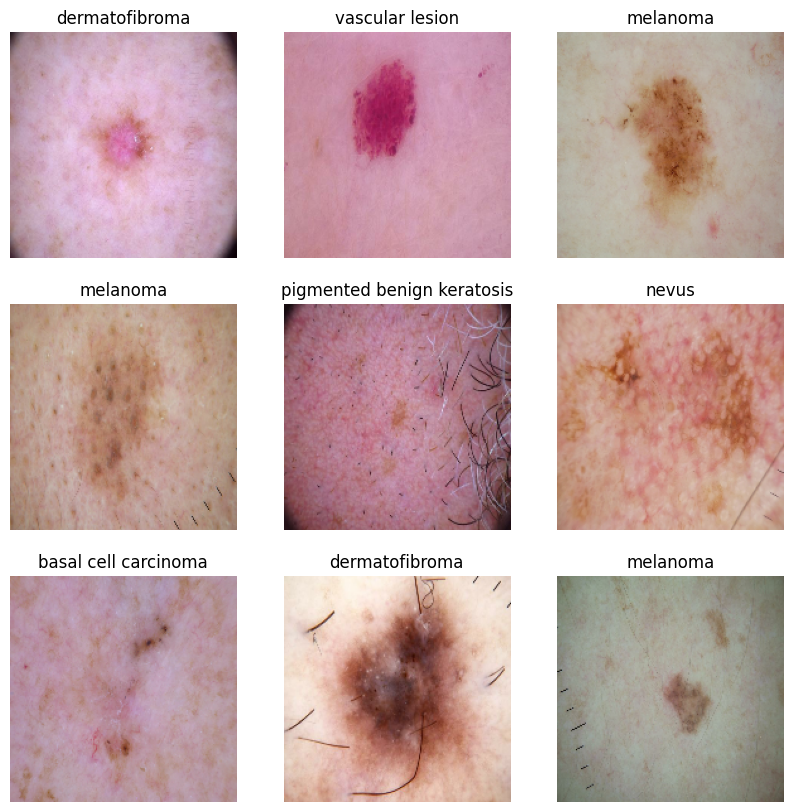

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training

In [27]:

#AUTOTUNE = tf.data.experimental.AUTOTUNE
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
preprocessing_layers = [
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3))
]

c:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\myenv3910\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [35]:
#Hyperparameters
input_shape = (180, 180, 3)
lr = 1e-5  # Learning rate
init = 'normal'
activ = 'relu'

# Model Definition
model = Sequential()

# Rescale Layer (Correct placement)
model.add(tf.keras.layers.Rescaling(1./255, input_shape=input_shape))

# First Conv Block
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))  
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Second Conv Block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Third Conv Block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # No need for extra Activation('relu')
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))  # Output layer for binary classification

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

## Number of classes is 9
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,322,793 (100.41 MB)

 Trainable params: 26,322,409 (100.41 MB)

 Non-trainable params: 384 (1.50 KB)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,322,793 (100.41 MB)

 Trainable params: 26,322,409 (100.41 MB)

 Non-trainable params: 384 (1.50 KB)

In [41]:
### Todo, choose an appropirate optimiser and loss function
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
# View the summary of all layers
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 176, 176, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 88, 88, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 86, 86, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 86, 86, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,322,793 (100.41 MB)

 Trainable params: 26,322,409 (100.41 MB)

 Non-trainable params: 384 (1.50 KB)

In [43]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 132s 767ms/step - accuracy: 0.3015 - loss: 2.4619 - val_accuracy: 0.1151 - val_loss: 2.3440
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 122s 719ms/step - accuracy: 0.5501 - loss: 1.3058 - val_accuracy: 0.1626 - val_loss: 2.7315
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 126s 748ms/step - accuracy: 0.6427 - loss: 1.0104 - val_accuracy: 0.4343 - val_loss: 1.5880
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 127s 754ms/step - accuracy: 0.7258 - loss: 0.8086 - val_accuracy: 0.7030 - val_loss: 0.8721
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 133s 789ms/step - accuracy: 0.7682 - loss: 0.6855 - val_accuracy: 0.7535 - val_loss: 0.7035
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 135s 799ms/step - accuracy: 0.8014 - loss: 0.5686 - val_accuracy: 0.7847 - val_loss: 0.6544
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 127s 753ms/step - accuracy: 0.8320 - loss: 0.4973 - val_accuracy: 0.7684 - val_loss: 0.6504
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 696ms/step - accuracy: 0.8466 -

<built-in method keys of dict object at 0x00000261C92DE280> :


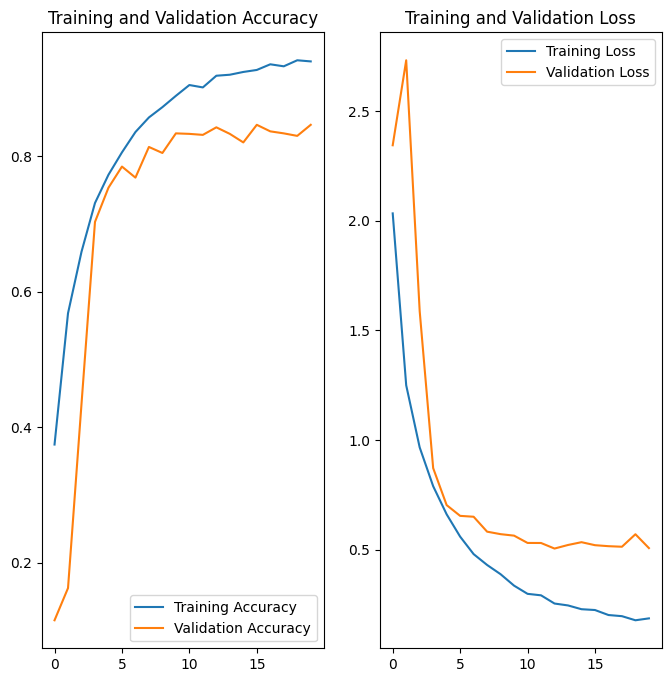

In [45]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.9630 - loss: 0.0993
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.8438 - loss: 0.5176
Accuracy:  0.9688427448272705
Validation Accuracy:  0.846325159072876
Loss:  0.08927679061889648
Validation Loss 0.5074686408042908


<Figure size 1000x1000 with 0 Axes>

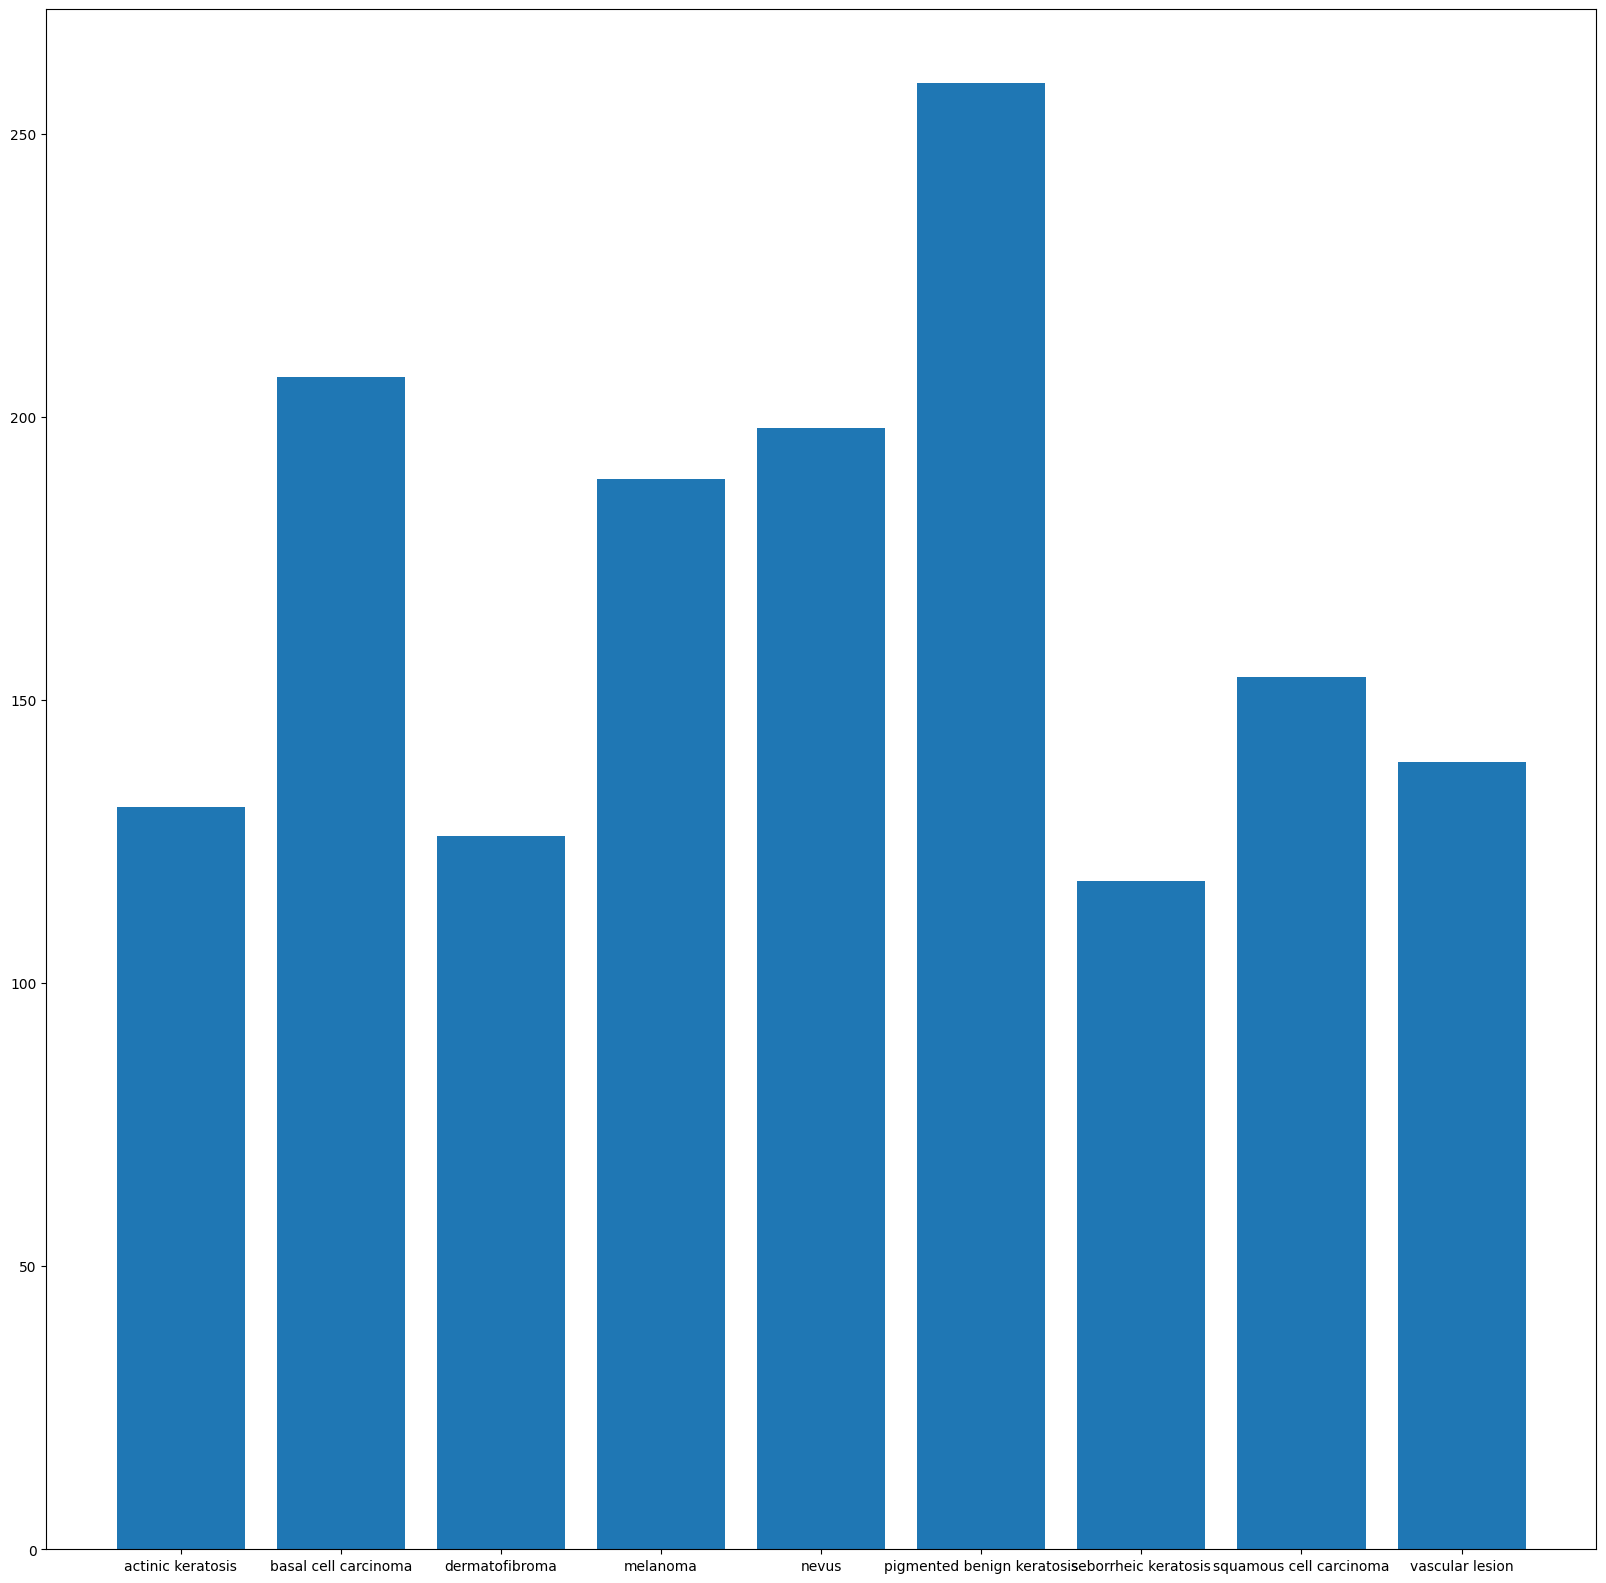

In [46]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [47]:
!pip install Augmentor


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
print("Base dataset path:", path_to_training_dataset)
print("Full class path:", class_path)

NameError: name 'path_to_training_dataset' is not defined

In [49]:
import Augmentor
import os

# Define the path to training dataset
path_to_training_dataset = r"C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train"

# Augment each class separately
for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)  # Correct path handling

    # Initialize Augmentor Pipeline
    p = Augmentor.Pipeline(class_path)
    
    # Apply transformations
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    # Generate 500 augmented samples per class
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x262631F33D0>: 100%|██████████| 500/500 [00:01<00:00, 328.25 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x261EFAB3F40>: 100%|██████████| 500/500 [00:01<00:00, 314.96 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x261F080E2E0>: 100%|██████████| 500/500 [00:01<00:00, 314.31 Samples/s]


Initialised with 438 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x262631F6B80>: 100%|██████████| 500/500 [00:05<00:00, 86.24 Samples/s]  


Initialised with 357 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x261EFCDA2B0>: 100%|██████████| 500/500 [00:05<00:00, 95.68 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x261EE94F820>: 100%|██████████| 500/500 [00:01<00:00, 301.24 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x261EFB45610>: 100%|██████████| 500/500 [00:02<00:00, 176.55 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x261EFA12940>: 100%|██████████| 500/500 [00:01<00:00, 331.94 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to C:\Users\Mohnish Deorukhkar\Desktop\Python\ASSIGNMENT\melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x261F0184CD0>: 100%|██████████| 500/500 [00:01<00:00, 347.33 Samples/s]                  


In [50]:

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


In [51]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

TypeError: 'module' object is not callable